# Convolutional Neural Net with Word Embeddings
Adapted from code at https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py

This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs.
90s/epoch on Intel i5 2.4Ghz CPU.
10s/epoch on Tesla K40 GPU.

## Import modules

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarn

### Set parameters

In [2]:
max_features = 5000
maxlen = 80    # max sentense length
batch_size = 32
embedding_dims = 50
filters = 250    # the number of output filters in the convolution
kernel_size = 3  # length of the 1D convolution window
hidden_dims = 250
epochs = 2

## Loading data

In [6]:
# Fix for:
#    ValueError: Object arrays cannot be loaded when allow_pickle=False
# save np.load
import numpy as np
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [7]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [8]:
print('Pad sequences (samples x length)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x length)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [9]:
x_train[0]

array([  15,  256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,
        530,  476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,
        104,   88,    4,  381,   15,  297,   98,   32, 2071,   56,   26,
        141,    6,  194,    2,   18,    4,  226,   22,   21,  134,  476,
         26,  480,    5,  144,   30,    2,   18,   51,   36,   28,  224,
         92,   25,  104,    4,  226,   65,   16,   38, 1334,   88,   12,
         16,  283,    5,   16, 4472,  113,  103,   32,   15,   16,    2,
         19,  178,   32], dtype=int32)

## Defining the network

In [34]:
model = Sequential()

We start off with an efficient embedding layer which maps
our vocab indices into embedding_dims dimensions

In [35]:
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2))

We add a `Convolution1D`, which will learn word group filters of size `kernel_size`:

In [36]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

We use max pooling:

In [37]:
model.add(GlobalMaxPooling1D())

We add a vanilla hidden layer:

In [38]:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

We project onto a single unit output layer, and squash it with a sigmoid:

In [39]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show the model

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 50)            250000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 80, 1)             51        
_________________________________________________________________
activation_5 (Activation)    (None, 80, 1)             0         
Total params: 250,051
Trainable params: 250,051
Non-trainable params: 0
_________________________________________________________________


### Plot model

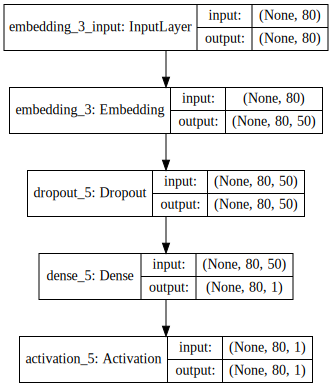

In [32]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

Warning: this hangs on Chrome while doing output. 

In [33]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

ValueError: Error when checking target: expected activation_5 to have 3 dimensions, but got array with shape (25000, 1)

## Testing
We already used test data during training to check accuracy on held out data, so this step isn't really necessary.

However, let's see how to do it after the training.

In [32]:
predictions = model.predict(x_test)

In [33]:
predictions

array([[0.07439587],
       [0.66296506],
       [0.850616  ],
       ...,
       [0.04226646],
       [0.05053277],
       [0.57305586]], dtype=float32)

In [34]:
predictions.round()

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [35]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

In [36]:
import numpy as np
errors = y_test-predictions.round().flatten()
errors

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [37]:
len(errors[errors==0])

21083

In [38]:
len(errors[errors==0])/len(errors)

0.84332

## Exploring the embeddings

In [39]:
model.layers

In [40]:
embeddings = model.get_weights()[0]
embeddings.shape

(5000, 50)

In [41]:
embeddings[0]

array([ 0.03307682,  0.07603284,  0.00780922,  0.02893462,  0.01586755,
        0.01034221,  0.05491837, -0.06895204, -0.02719527,  0.02008788,
        0.01397348, -0.05552543,  0.07401559, -0.00365608,  0.09408828,
       -0.02566647,  0.0255305 ,  0.01045604,  0.00517676,  0.0156726 ,
        0.07024366, -0.03207979, -0.02388623,  0.01181468, -0.02443209,
       -0.04143047,  0.04815837,  0.0269528 ,  0.07293575,  0.03123729,
       -0.05305878, -0.06926571,  0.02563779, -0.05743494,  0.0639803 ,
       -0.03636751, -0.02860104, -0.04724038, -0.00982183, -0.04162591,
        0.07022654, -0.00401301, -0.00611663,  0.08936445,  0.00896432,
       -0.04207487, -0.05006573,  0.03158859, -0.03399568, -0.01459223],
      dtype=float32)

In [42]:
embeddings[0].dot(embeddings[1])

-0.036399107

## Comparison with one-hot representations

In [45]:
model_one_hot = Sequential()

This is NOT a real embedding layer, it is just a trick 
to convert words into one-hot representations.

Note that the embeddinfs are not trained, thet never changes during training.

In [47]:
model_one_hot.add(Embedding(max_features,
                    max_features,
                    embeddings_initializer='identity',
                    input_length=maxlen,
                    trainable=False))  # do not train the embeddings

model_one_hot.add(Dropout(0.2))

We add a `Convolution1D`, which will learns word group filters of size kernel_size:

In [48]:
model_one_hot.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

We use max pooling:

In [49]:
model_one_hot.add(GlobalMaxPooling1D())

We add a vanilla hidden layer:

In [50]:
model_one_hot.add(Dense(hidden_dims))
model_one_hot.add(Dropout(0.2))
model_one_hot.add(Activation('relu'))

We project onto a single unit output layer, and squash it with a sigmoid:

In [51]:
model_one_hot.add(Dense(1))
model_one_hot.add(Activation('sigmoid'))

Compile the model:

In [52]:
model_one_hot.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show model

In [53]:
model_one_hot.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 5000)          25000000  
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 5000)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 78, 250)           3750250   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 250)               0         
__________

### Train the model

In [54]:
model_one_hot.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 384s 15ms/step - loss: 0.4763 - acc: 0.7556 - val_loss: 0.3487 - val_acc: 0.8509

In [ ]:
one_hot = model_one_hot.get_weights()[0]
one_hot.shape

In [ ]:
one_hot[0]